In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_folder = 'data'
site = 'avenal-movie-theatre'

# Import data

# Power consumption data

In [3]:
df_raw = pd.read_csv(data_folder + '/power_' + site + '.csv', index_col=[0], parse_dates=True)
df_raw = df_raw[(df_raw.index < '2019-04-01')]
df_raw.head()

,power
datetime,
2018-01-01 00:00:04.574889+00:00,400.0
2018-01-01 00:00:10.215095+00:00,440.0
2018-01-01 00:00:13.496753+00:00,440.0
2018-01-01 00:00:20.031088+00:00,440.0
2018-01-01 00:00:33.525473+00:00,400.0


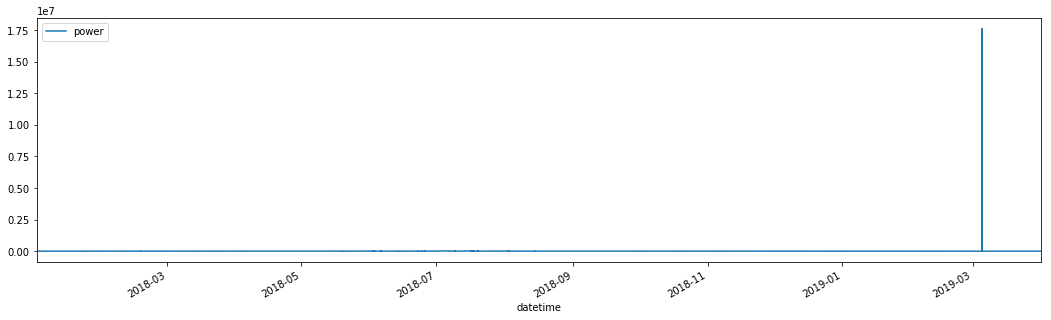

In [4]:
df_raw.plot(figsize=(18,5))

# HVAC States data

In [5]:
# df_raw_hvac_states = pd.read_csv(data_folder + '/hvac_states_' + site + '.csv', index_col=[0], parse_dates=True)
# df_raw_hvac_states.head()

In [6]:
# import time
# start = time.clock()

# for var in list(df_raw_hvac_states.columns):
    
#     print('var: ', var)

#     add_var = pd.get_dummies(df_raw_hvac_states[var], prefix=var, drop_first=True)

#     # Add all the columns to the model data
#     df_raw_hvac_states = df_raw_hvac_states.join(add_var)

#     # Drop the original column that was expanded
#     df_raw_hvac_states.drop(columns=[var], inplace=True)
    
# df_raw_hvac_states.head()

# print('Time: ', time.clock() - start)

In [7]:
# df_raw = pd.concat([df_raw_power, data], axis=1)
# df_raw.head()

# Clean data

Resample data to 1hour interval, remove outliers and drop NaN's.

In [8]:
df_processed = df_raw.resample('15T').mean()
df_processed = df_processed[df_processed['power'] < 10000000]
df_processed = df_processed[(np.abs(stats.zscore(df_processed)) < float(3)).all(axis=1)]
df_processed.dropna(inplace=True)
df_processed.head()

,power
datetime,
2018-01-01 00:00:00+00:00,416.991150
2018-01-01 00:15:00+00:00,477.477477
2018-01-01 00:30:00+00:00,430.990991
2018-01-01 00:45:00+00:00,504.081633
2018-01-01 01:00:00+00:00,453.565217


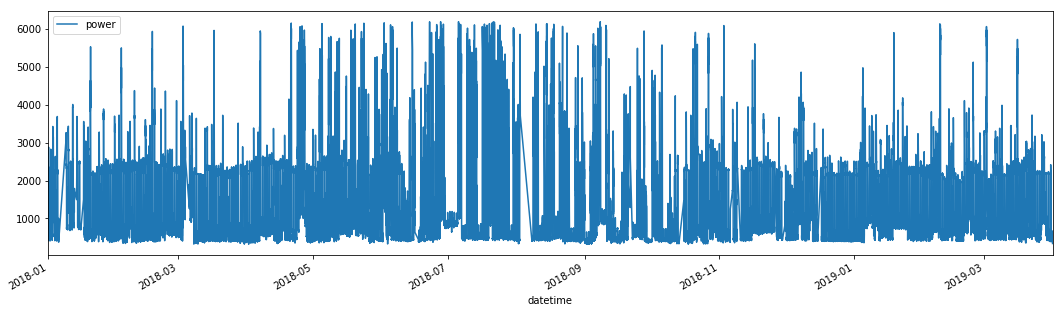

In [9]:
df_processed.plot(figsize=(18,5))

# Add quarterly box plots

# Check for stationarity
# Make data stationary

# Normalize data

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
df_normalized = pd.DataFrame(scaler.fit_transform(df_processed), 
                             columns=df_processed.columns, index=df_processed.index)
df_normalized.head()

,power
datetime,
2018-01-01 00:00:00+00:00,0.016522
2018-01-01 00:15:00+00:00,0.026825
2018-01-01 00:30:00+00:00,0.018907
2018-01-01 00:45:00+00:00,0.031357
2018-01-01 01:00:00+00:00,0.022752


In [11]:
df_normalized.shape

(40343, 1)

# Check for stationarity

Since Test Statistic < Critical Value (1%) --> Data is stationary

In [12]:
result = adfuller(df_normalized['power'], autolag='AIC')
output = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                      '#Observations Used'])
for key, value in result[4].items():
    output['Critical Value (%s)' % key] = value
    
output

Test Statistic            -30.665127
p-value                     0.000000
#Lags Used                 48.000000
#Observations Used      40294.000000
Critical Value (1%)        -3.430512
Critical Value (5%)        -2.861612
Critical Value (10%)       -2.566808
dtype: float64

# ACF and PACF

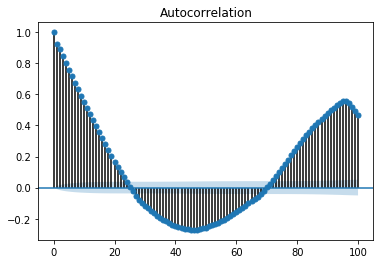

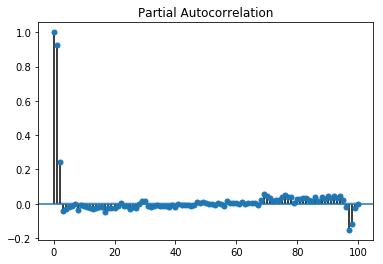

In [13]:
fig1 = plot_acf(df_normalized, lags=100)
fig2 = plot_pacf(df_normalized, lags=100)

# Prepare data

In [14]:
train_size = int(0.8 * len(df_normalized.values))
training_set = df_normalized.values[:train_size]
X_train, y_train = [], []

for i in range(10, len(training_set)-16):
    X_train.append(training_set[i-10:i])
    y_train.append(training_set[i:i+16])
    
X_train, y_train = np.array(X_train), np.array(y_train)

# # Reshaping
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# y_train = np.reshape(y_train, (y_train.shape[0]))

print(X_train.shape)
print(y_train.shape)

(32248, 10, 1)
(32248, 16, 1)


In [18]:
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1]))

In [19]:
y_train.shape

(32248, 16)

# LSTM

In [52]:
model = Sequential()

model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# model.add(RepeatVector(n=16))

model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=128, activation='softmax', return_sequences=False))
model.add(Dropout(0.2))

# model.add(TimeDistributed(Dense(units=1)))
model.add(Dense(16))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10, 128)           66560     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 128)           131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                2064      
Total para

In [57]:
historyr = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
32248/32248 [==============================] - 23s 704us/step - loss: 0.0198 - acc: 0.1621
Epoch 2/5
32248/32248 [==============================] - 23s 720us/step - loss: 0.0196 - acc: 0.1616
Epoch 3/5
32248/32248 [==============================] - 24s 758us/step - loss: 0.0193 - acc: 0.1629
Epoch 4/5
32248/32248 [==============================] - 27s 853us/step - loss: 0.0192 - acc: 0.1627
Epoch 5/5
32248/32248 [==============================] - 29s 900us/step - loss: 0.0191 - acc: 0.1615


In [60]:
loss = historyr.history['loss']
acc  = historyr.history['acc']
epochs = [x for x in range(len(loss))]

In [64]:
acc

[0.1620875713231767,
 0.16159141652195486,
 0.16289382286903964,
 0.162707764818928,
 0.1614983874932024]

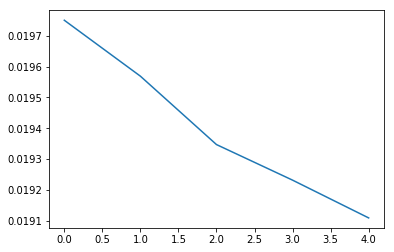

In [65]:
plt.plot(epochs, loss)

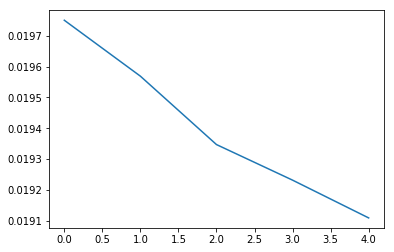

In [66]:
plt.plot(epochs, loss)

In [23]:
testing_set = df_normalized.values[train_size:]
X_test, y_test = [], []

for i in range(10, len(testing_set)-16):
    X_test.append(testing_set[i-10:i])
    y_test.append(testing_set[i:i+16])    

X_test, y_test = np.array(X_test), np.array(y_test)
    
# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

print(X_test.shape)
print(y_test.shape)

(8043, 10, 1)
(8043, 16)


In [24]:
y_pred_normalized = model.predict(X_test)
y_pred_normalized.shape

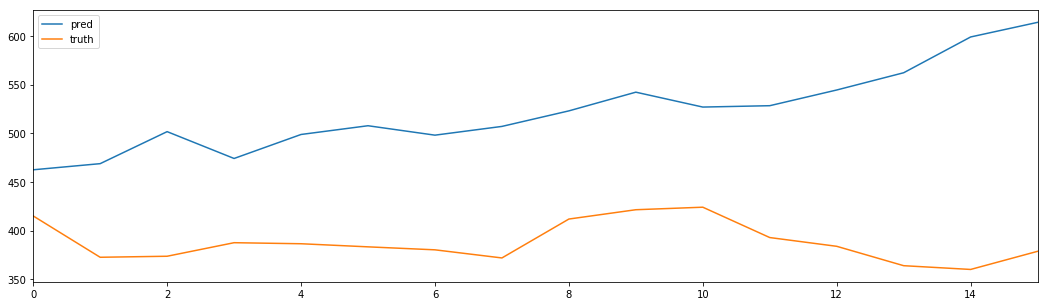

In [50]:
for i in range(len(y_pred_normalized)):
    df_y_pred_normalized = pd.DataFrame(y_pred_normalized[i],
                                        index=df_normalized.values[train_size+i:train_size+i+16],
                                        columns=df_normalized.columns)
    pred_value = scaler.inverse_transform(df_y_pred_normalized)
    
    
    df_y_true_normalized = pd.DataFrame(y_test[i],
                                        index=df_normalized.values[train_size+i:train_size+i+16],
                                        columns=df_normalized.columns)
    truth_value = scaler.inverse_transform(df_y_true_normalized)
    
    # print(len(truth_value))
    # break
    
    df_plot = pd.concat([pd.DataFrame(pred_value, columns=['pred']), 
                         pd.DataFrame(truth_value, columns=['truth'])], axis=1)
    df_plot.plot(figsize=(18,5))
    
    break

In [32]:
# new_y_pred = []
# for i in range(y_pred_normalized.shape[0]):
#     temp = scaler.inverse_transform(y_pred_normalized[i])
#     new_y_pred.append(temp)

In [33]:
# y_pred = scaler.inverse_transform(y_pred_normalized)

# df_y_pred = pd.DataFrame(y_pred, 
#                          columns=df_normalized[train_size:].columns, 
#                          index=df_normalized[train_size+10:].index)
# df_y_pred.head()

In [34]:
# y_true = scaler.inverse_transform([y_test])
# y_true_reshape = np.reshape(y_true, (y_true.shape[1], y_true.shape[0]))
# df_y_test = pd.DataFrame(y_true_reshape, 
#                          columns=df_normalized[train_size:].columns, 
#                          index=df_normalized[train_size+10:].index)
# df_y_test.head()

In [ ]:
# df_plot = pd.concat([df_y_pred, df_y_test], axis=1)
# df_plot.columns = ['y_pred', 'y_true']
# df_plot.plot(figsize=(18,5))

# Plots

## Training & Testing Error

## Predictions